# Classification

## Objectives

*  Fit and evaluate a classification model to predict if a prospect will churn or not.

## Inputs

* outputs/datasets/collection/TelcoCustomerChurn.csv
* Instructions on which variables to use for data cleaning and feature engineering. They are found in each respective notebook.

## Outputs

* Train set (features and target)
* Test set (features and target)
* Data cleaning and Feature Engineering pipeline
* Modeling pipeline
* Feature importance plot



---

# Change working directory

Change the working directory from its current folder to its parent folder


In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/Film_Hit_prediction/jupyter_notebooks'

Make the parent of the current directory the new current directory.


In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/Film_Hit_prediction'

---

# Load Data 

Load Encoder

In [4]:
import joblib
import pandas as pd
import numpy as np

le_language = joblib.load('language_encoder.joblib')
scaler = joblib.load('scaler.joblib')


Load Data

In [5]:
X_train_final = pd.read_csv('X_train_final.csv')
X_test_final = pd.read_csv('X_test_final.csv') 

Load Target Variables

In [6]:
y_train = pd.read_csv('outputs/datasets/cleaned/y_train_cleaned.csv')
y_test = pd.read_csv('outputs/datasets/cleaned/y_test_cleaned.csv')

In [7]:
#Check to ensure everything loaded correctly
print("Data shapes:")
print("X_train_final:", X_train_final.shape)
print("X_test_final:", X_test_final.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

Data shapes:
X_train_final: (3842, 22)
X_test_final: (961, 22)
y_train: (3842, 1)
y_test: (961, 1)


---

# Step 2: ML Pipeline with all data

## ML Pipeline for Modelling and Hyperparameter Optimisation

In [8]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Define models

models = {
    'Linear Regression': {
        'model': LinearRegression(),
        'params': {}
    },
    'Ridge': {
        'model': Ridge(),
        'params': {
            'alpha': [0.1, 1.0, 10.0]
        }
    },
    'Lasso': {
        'model': Lasso(),
        'params': {
            'alpha': [0.1, 1.0, 10.0]
        }
    },
    'Random Forest': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5]
        }
    }
}


# Grid Search

In [9]:


results = {}
best_models = {}

for name, model_info in models.items():
    print(f"\nTraining {name}...")

    # GridSearchCV performs the hyperparameter optimization
    grid_search = GridSearchCV(
        model_info['model'],
        model_info['params'],
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )

  


Training Linear Regression...

Training Ridge...

Training Lasso...

Training Random Forest...


# Fit the model with different parameter combinations

In [10]:
grid_search.fit(X_train_final, y_train)

/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:598: DataCon

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20, None],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='neg_mean_squared_error')

 Save best model and its parameters

In [11]:
best_models[name] = grid_search.best_estimator_
y_pred = grid_search.predict(X_test_final)

results[name] = {
    'Best Parameters': grid_search.best_params_,
    'Best Score': -grid_search.best_score_
}


Calcualte multiple metrics

In [12]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

results[name] = {
    'Best Parameters': grid_search.best_params_,
    'RMSE': rmse,
    'R2 Score': r2,
    'MAE': mae
}



# Print results

In [14]:
print("\nHyperparameter Optimization Results:")
for name, metrics in results.items():
    print(f"\n{name}:")
    print(f"Best Parameters: {metrics['Best Parameters']}")
    print(f"RMSE: {metrics['RMSE']:,.2f}")
    print(f"R² Score: {metrics['R2 Score']:.4f}")
    print(f"MAE: {metrics['MAE']:,.2f}")


Hyperparameter Optimization Results:

Random Forest:
Best Parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
RMSE: 99,524,937.66
R² Score: 0.6197
MAE: 54,721,840.88


# Save best overall model

In [16]:
best_model_name = max(results.items(), key=lambda x: x[1]['R2 Score'])[0]
joblib.dump(best_models[best_model_name], 'best_model.joblib')
print(f"\nBest performing model was {best_model_name} with R² Score: {results[best_model_name]['R2 Score']:.4f}")


Best performing model was Random Forest with R² Score: 0.6197


## Assess feature importance


Top 10 Most Important Features:
            Feature  Importance
1     budget_scaled    0.818169
4         Animation    0.021368
3         Adventure    0.021010
16          Romance    0.018197
10          Fantasy    0.016338
17  Science Fiction    0.015200
19         Thriller    0.013223
9            Family    0.013069
5            Comedy    0.012888
8             Drama    0.012600


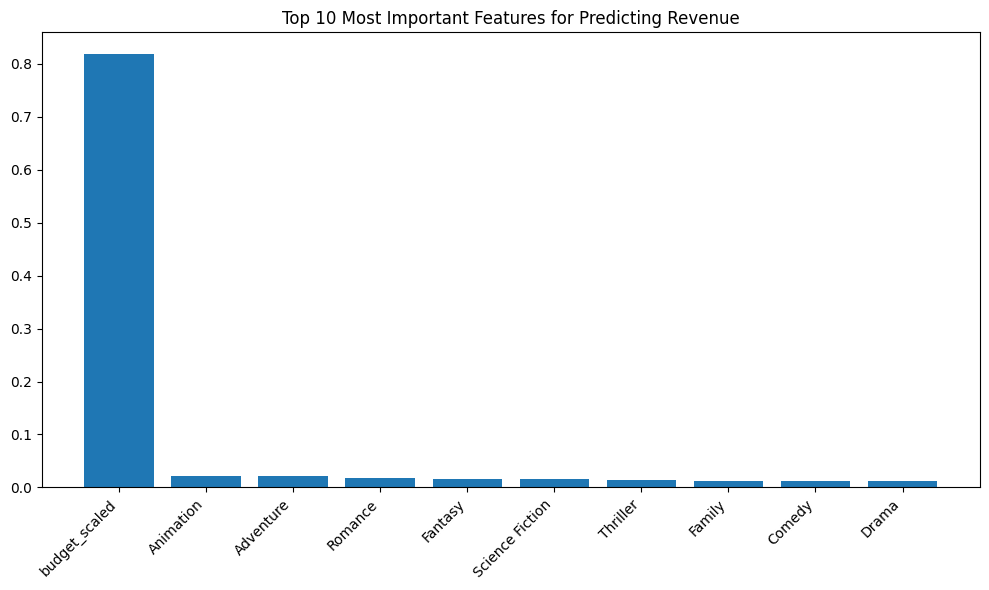

In [17]:
# Get feature importance from Random Forest model
feature_importance = pd.DataFrame({
    'Feature': X_train_final.columns,
    'Importance': best_models['Random Forest'].feature_importances_
})

# Sort by importance and show top features
feature_importance = feature_importance.sort_values('Importance', ascending=False)

# Print feature importance
print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

# Optional: Create a bar plot of feature importance
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(feature_importance['Feature'][:10], feature_importance['Importance'][:10])
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Most Important Features for Predicting Revenue')
plt.tight_layout()
plt.show()